<a href="https://colab.research.google.com/github/DataSnek/ML-Project/blob/main/RegressionModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#  Imports and Setup
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Modeling Libraries
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Mount Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#load the data
file_path = '/content/drive/My Drive/instacart_train_data.pkl'
print(f"Loading data from {file_path}...")
data = pd.read_pickle(file_path)
print(f"Data Loaded Successfully. Shape: {data.shape}")

Loading data from /content/drive/My Drive/instacart_train_data.pkl...
Data Loaded Successfully. Shape: (8474661, 36)


In [20]:
#  Regression Data Preparation

# Define Target for Regression
#  predicting 'days until next order'
target_col = 'days_since_prior_order'

#  Handle Categorical Columns (if any remain object type)
for col in data.select_dtypes(include=['category', 'object']).columns:
    data[col] = data[col].astype('category').cat.codes

# Create Features (X) and Target (y)
if target_col not in data.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset!")

y_reg = data[target_col]

# Drop ID columns and the target itself
cols_to_drop = ['user_id', 'product_id', 'eval_set', 'order_id', 'reordered', target_col]
existing_cols_to_drop = [c for c in cols_to_drop if c in data.columns]
X_reg = data.drop(columns=existing_cols_to_drop)

groups = data['user_id'] # Keep groups for splitting

# User-Aware Splitting
print("Splitting data (User-Aware)...")
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in gss.split(X_reg, y_reg, groups):
    X_train, X_val = X_reg.iloc[train_idx], X_reg.iloc[val_idx]
    y_train, y_val = y_reg.iloc[train_idx], y_reg.iloc[val_idx]

print(f"Regression Training Data: {X_train.shape}")
print(f"Regression Validation Data: {X_val.shape}")

# Clean up raw data to save RAM
del data
gc.collect()

Splitting data (User-Aware)...
Regression Training Data: (6777721, 30)
Regression Validation Data: (1696940, 30)


368

In [21]:
# Regression Evaluation & Plotting Function
reg_results = {}

def evaluate_regression(name, y_true, y_pred):
    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Save for comparison
    reg_results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

    print(f"\n--- {name} Performance ---")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")

    # --- PLOTS ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    #  Actual vs Predicted
    indices = np.random.choice(len(y_true), size=min(2000, len(y_true)), replace=False)
    y_true_samp = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
    y_pred_samp = y_pred[indices]

    axes[0].scatter(y_true_samp, y_pred_samp, alpha=0.3, color='blue')
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[0].set_title(f'{name}: Actual vs Predicted')
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')

    #  Real vs Predicted
    residuals = y_true_samp - y_pred_samp
    axes[1].scatter(y_pred_samp, residuals, alpha=0.3, color='purple')
    axes[1].axhline(0, color='red', linestyle='--')
    axes[1].set_title(f'{name}: Residuals vs Predicted')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Residuals')

    # Residual Histogram
    sns.histplot(residuals, kde=True, ax=axes[2], color='green')
    axes[2].set_title(f'{name}: Residual Distribution')
    axes[2].set_xlabel('Residual Error')

    plt.tight_layout()
    plt.show()

Training Linear Regression (Ridge)...

--- Ridge Regression Performance ---
MAE:  0.0000
RMSE: 0.0000
R2:   1.0000


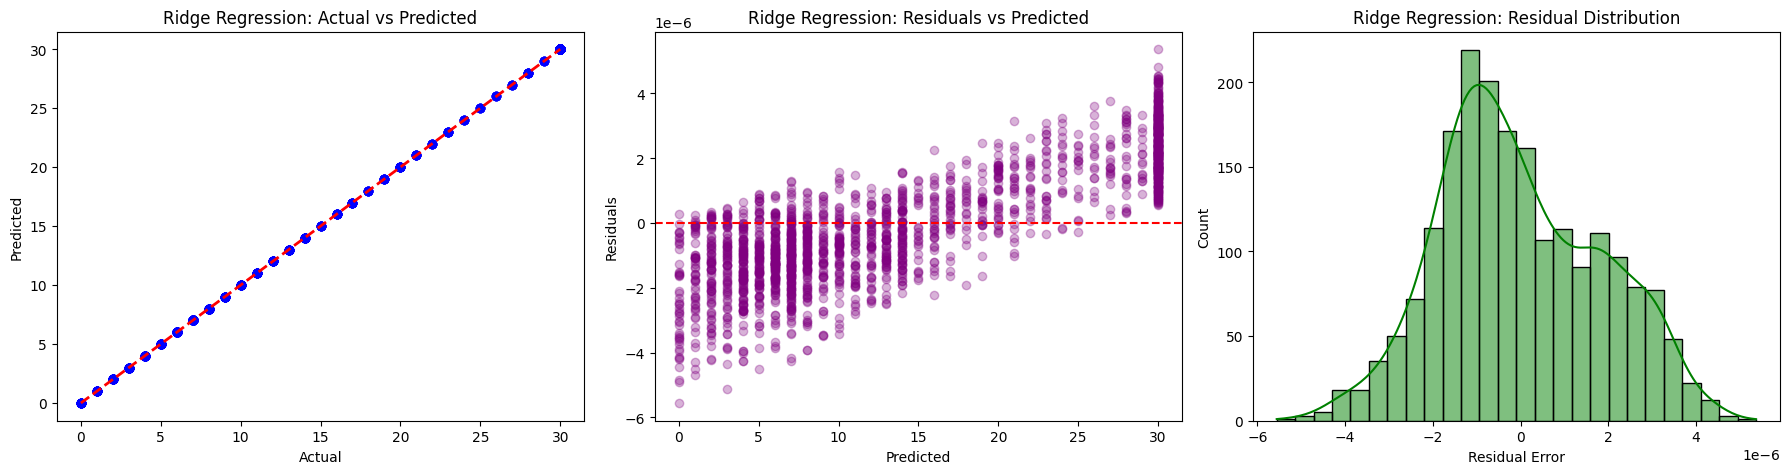

In [22]:
# Linear Regression (Ridge)
from sklearn.linear_model import Ridge

print("Training Linear Regression (Ridge)...")
reg_ridge_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

reg_ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = reg_ridge_pipeline.predict(X_val)

evaluate_regression("Ridge Regression", y_val, y_pred_ridge)

Training Linear SVR...

--- Linear SVR Performance ---
MAE:  0.0000
RMSE: 0.0000
R2:   1.0000


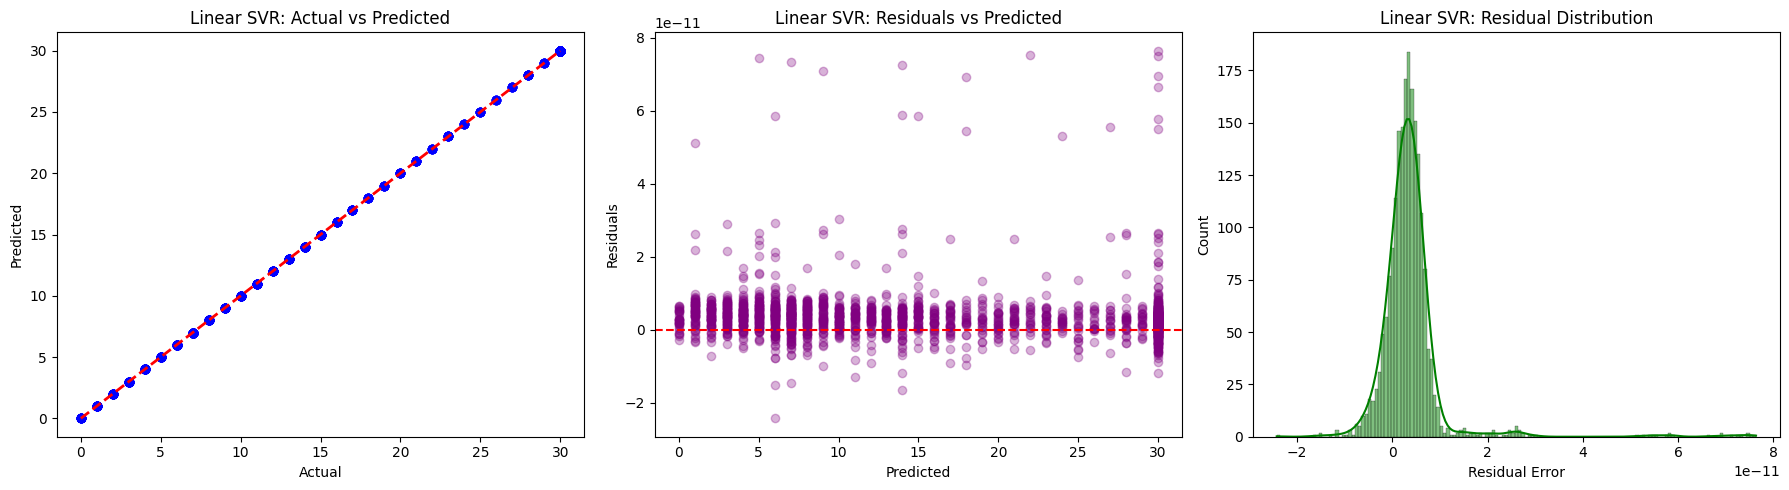

In [23]:
# Linear SVR
from sklearn.svm import LinearSVR

print("Training Linear SVR...")
reg_svr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', LinearSVR(random_state=42, max_iter=1000))
])

reg_svr_pipeline.fit(X_train, y_train)
y_pred_svr = reg_svr_pipeline.predict(X_val)

evaluate_regression("Linear SVR", y_val, y_pred_svr)

Training KNN Regressor (on subset)...


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:940: RuntimeWarning: invalid value encountered in divide
  numerator[valid_score] / denominator[valid_score]



--- KNN Regressor Performance ---
MAE:  2.8535
RMSE: 3.8038
R2:   nan


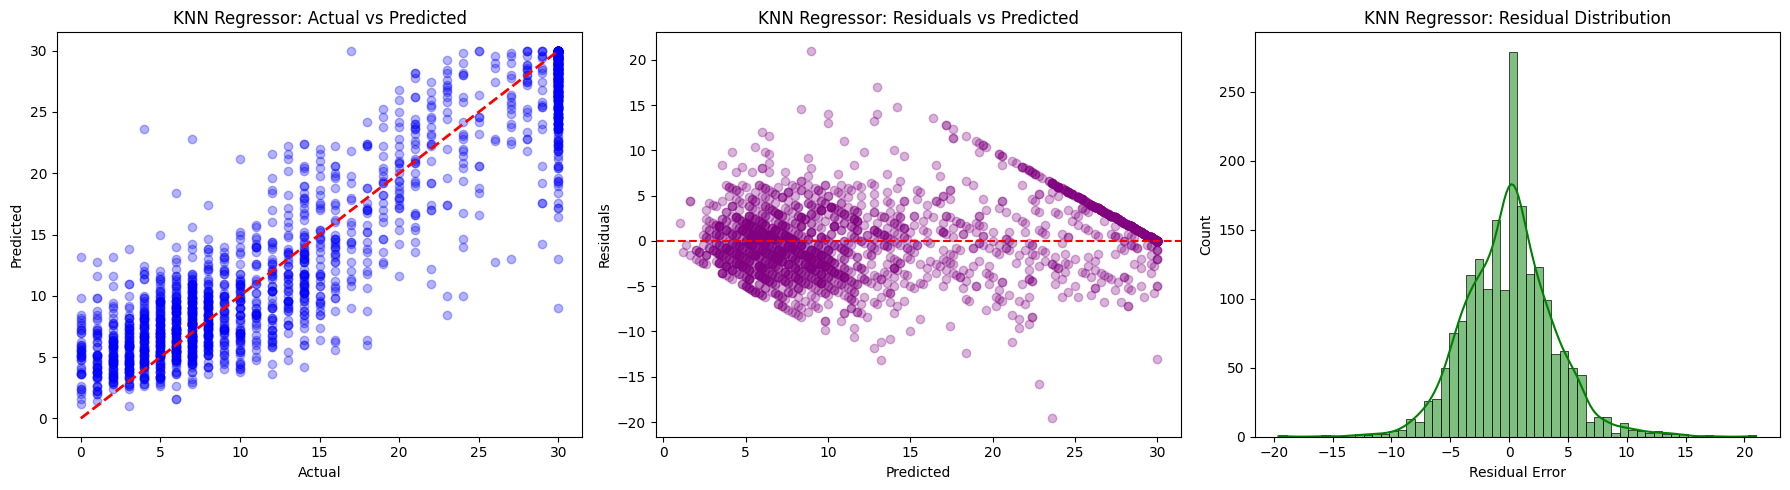

In [24]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

print("Training KNN Regressor (on subset)...")
# Subsampling for speed
subset_size = 50000
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train, train_size=subset_size, random_state=42
)

reg_knn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor(n_neighbors=5))
])

reg_knn_pipeline.fit(X_train_sub, y_train_sub)
y_pred_knn_reg = reg_knn_pipeline.predict(X_val)

evaluate_regression("KNN Regressor", y_val, y_pred_knn_reg)

Training Decision Tree Regressor...

--- Decision Tree Regressor Performance ---
MAE:  0.0000
RMSE: 0.0000
R2:   1.0000


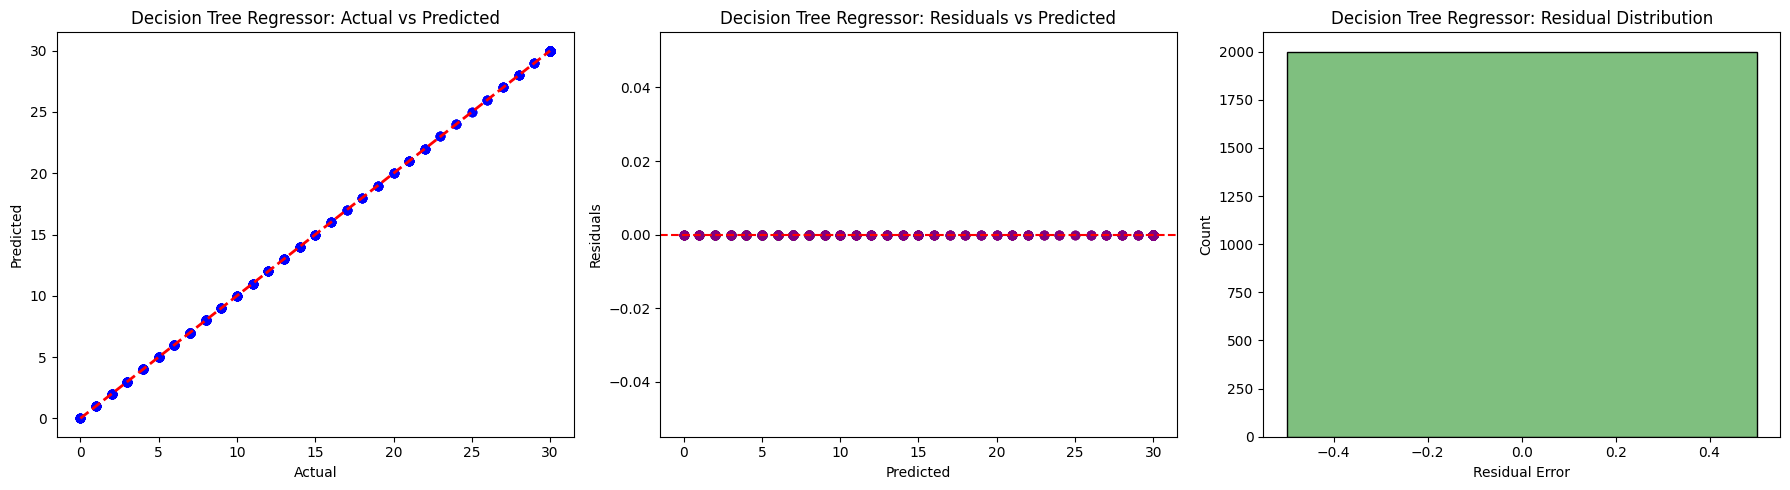

In [25]:
#  Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

print("Training Decision Tree Regressor...")
reg_dt_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('model', DecisionTreeRegressor(max_depth=8, random_state=42))
])

reg_dt_pipeline.fit(X_train, y_train)
y_pred_dt_reg = reg_dt_pipeline.predict(X_val)

evaluate_regression("Decision Tree Regressor", y_val, y_pred_dt_reg)

Training Random Forest Regressor...

--- Random Forest Regressor Performance ---
MAE:  0.0000
RMSE: 0.0000
R2:   1.0000


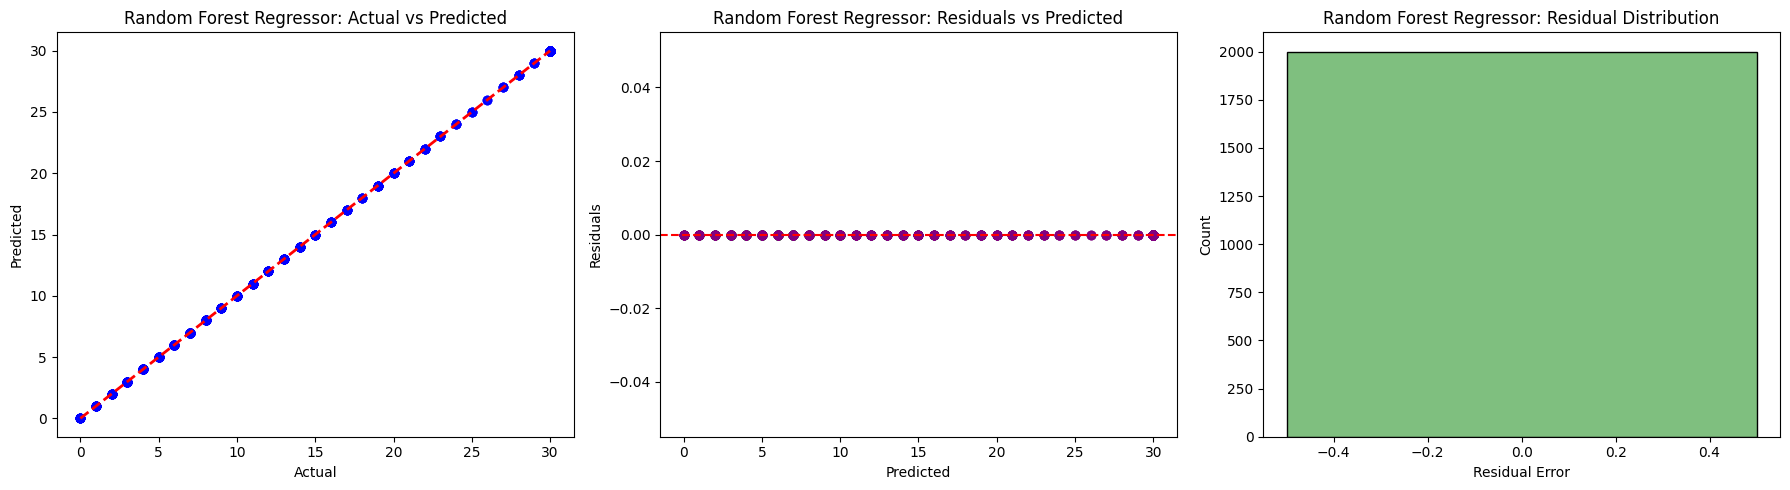

In [26]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

print("Training Random Forest Regressor...")
reg_rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('model', RandomForestRegressor(
        n_estimators=30,
        max_depth=10,
        n_jobs=-1,
        random_state=42
    ))
])

reg_rf_pipeline.fit(X_train, y_train)
y_pred_rf_reg = reg_rf_pipeline.predict(X_val)

evaluate_regression("Random Forest Regressor", y_val, y_pred_rf_reg)

Training XGBoost Regressor...

--- XGBoost Regressor Performance ---
MAE:  0.0002
RMSE: 0.0003
R2:   1.0000


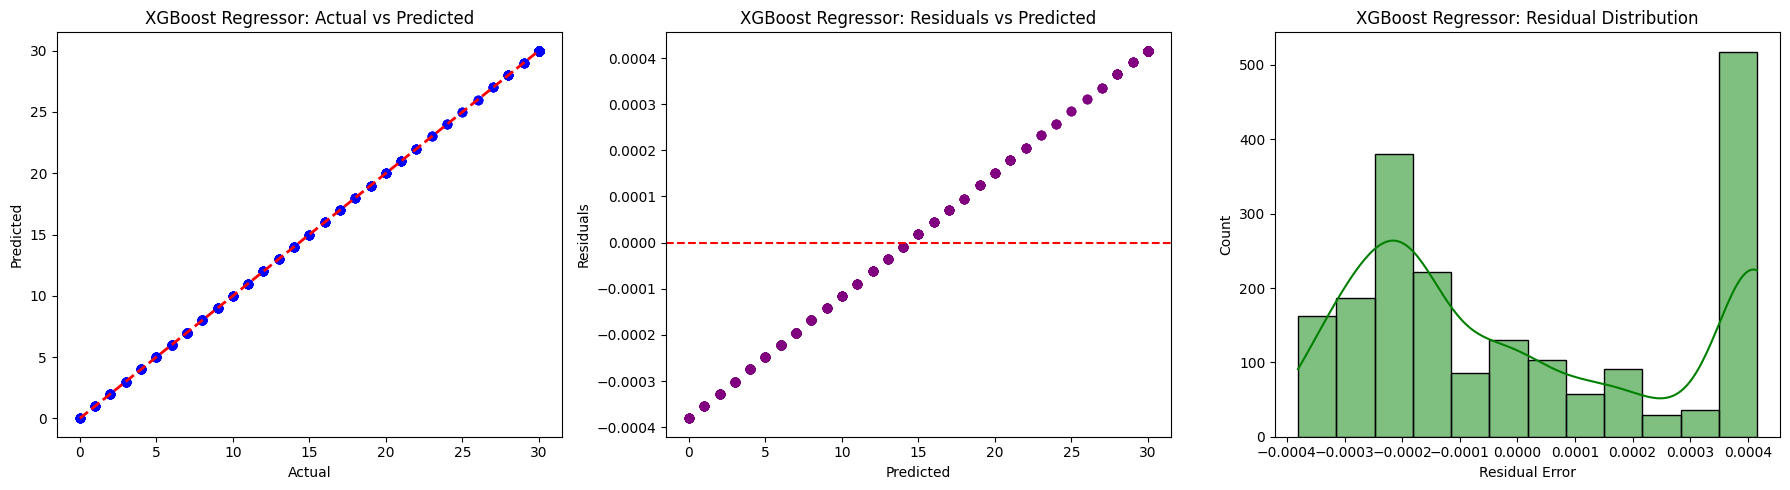

In [27]:
# XGBoost Regressor
from xgboost import XGBRegressor

print("Training XGBoost Regressor...")
xgb_regressor = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    n_jobs=-1,
    random_state=42,
    objective='reg:squarederror'
)

xgb_regressor.fit(X_train, y_train)
y_pred_xgb_reg = xgb_regressor.predict(X_val)

evaluate_regression("XGBoost Regressor", y_val, y_pred_xgb_reg)

Summary of Regression Models:
                                  MAE          RMSE   R2
Ridge Regression         1.511867e-06  1.846983e-06  1.0
Linear SVR               4.647132e-12  8.547029e-12  1.0
KNN Regressor            2.853516e+00  3.803781e+00  NaN
Decision Tree Regressor  0.000000e+00  0.000000e+00  1.0
Random Forest Regressor  0.000000e+00  0.000000e+00  1.0
XGBoost Regressor        2.438079e-04  2.759844e-04  1.0


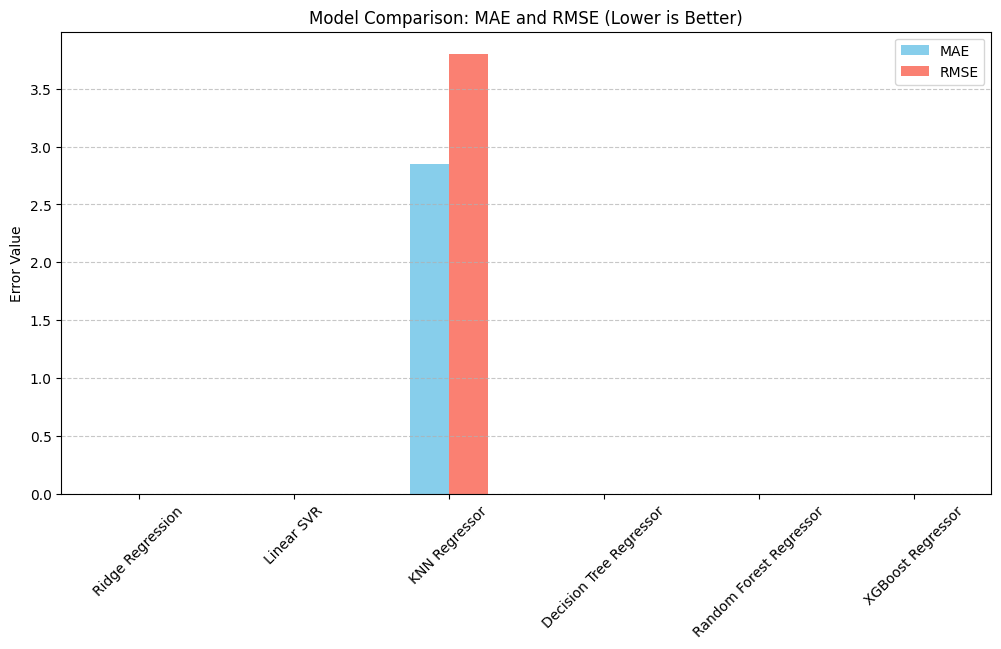

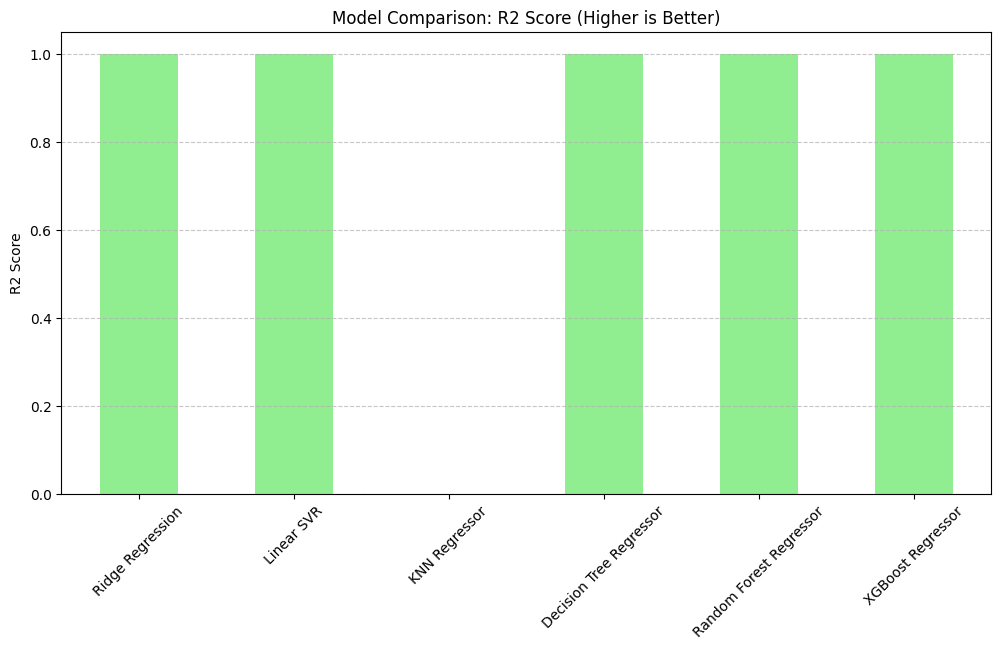

In [28]:
#  Regression Model Comparison
results_df = pd.DataFrame(reg_results).T

print("Summary of Regression Models:")
print(results_df)

# Plotting MAE and RMSE Comparison
results_df[['MAE', 'RMSE']].plot(kind='bar', figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title('Model Comparison: MAE and RMSE (Lower is Better)')
plt.ylabel('Error Value')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plotting R2 Comparison
plt.figure(figsize=(12, 6))
results_df['R2'].plot(kind='bar', color='lightgreen')
plt.title('Model Comparison: R2 Score (Higher is Better)')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()